In [121]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

from tqdm import tqdm

# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

np.random.seed(seed=42)

In [122]:
anime = pd.read_csv('data/anime.csv')
ratings = pd.read_csv('data/rating.csv')

anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [123]:
print(ratings.shape)
ratings.head()

(7813737, 3)


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [124]:
ratings = ratings[ratings.rating != -1]
ratings['rating'].unique()

array([10,  8,  6,  9,  7,  3,  5,  4,  1,  2], dtype=int64)

In [125]:
from scipy.special import erfc

def chauvenet(array):
    mean = array.mean()
    stdv = array.std()
    n = len(array)
    criterion = 1.0/(2*n)
    d = abs(array-mean)/stdv
    prob = erfc(d)
    return prob < criterion

In [126]:
count_reviews = ratings.groupby('user_id')['anime_id'].count()
count_reviews

user_id
1          4
2          1
3         92
5        459
7        343
        ... 
73512     12
73513     33
73514      1
73515    179
73516      2
Name: anime_id, Length: 69600, dtype: int64

In [127]:
outlier_users = count_reviews[chauvenet(count_reviews)]
outlier_users

user_id
226      742
271      599
294      675
392      598
446      743
        ... 
73356    565
73362    596
73378    723
73395    585
73499    603
Name: anime_id, Length: 1216, dtype: int64

In [128]:
print('Критерий Шавене определил выбросами тех пользователей, у которых количество просмотренных аниме сильно отличается от среднего значения')
print('В данном случае, пользователи с количеством просмотренных аниме, сильно выходящим за общий тренд, считаются выбросами')
print('Рекомендательная система нужна для выборосов, меньших среднего значения, чтобы эти пользователи могли получить рекомендации по аниме, которые им могут понравиться, чтобы смотреть больше аниме. Напротив, выбросы, большие среднего значения, не нуждаются в рекомендательной системе, так как они уже смотрят много аниме')

bad_user_threshold = outlier_users.min()
bad_user_threshold

Критерий Шавене определил выбросами тех пользователей, у которых количество просмотренных аниме сильно отличается от среднего значения
В данном случае, пользователи с количеством просмотренных аниме, сильно выходящим за общий тренд, считаются выбросами
Рекомендательная система нужна для выборосов, меньших среднего значения, чтобы эти пользователи могли получить рекомендации по аниме, которые им могут понравиться, чтобы смотреть больше аниме. Напротив, выбросы, большие среднего значения, не нуждаются в рекомендательной системе, так как они уже смотрят много аниме


522

In [129]:
count_reviews = count_reviews.rename('count_reviews')
ratings = ratings.merge(count_reviews, on='user_id')
ratings = ratings[ratings['count_reviews'] < bad_user_threshold]
ratings

,user_id,anime_id,rating,count_reviews
0,1,8074,10,4
1,1,11617,10,4
2,1,11757,10,4
3,1,15451,10,4
4,2,11771,10,1
...,...,...,...,...
6337236,73515,16512,7,179
6337237,73515,17187,9,179
6337238,73515,22145,10,179
6337239,73516,790,9,2


In [130]:
median = ratings['count_reviews'].median()
ratings = ratings[ratings['count_reviews'] > median]
ratings = ratings.drop(columns=['count_reviews'])
ratings

,user_id,anime_id,rating
97,5,6,8
98,5,15,6
99,5,17,6
100,5,18,6
101,5,20,6
...,...,...,...
6337234,73515,13659,8
6337235,73515,14345,7
6337236,73515,16512,7
6337237,73515,17187,9


In [131]:
outlier_anime = anime[chauvenet(anime['rating'])]
anime = anime.drop(index=outlier_anime.index)
anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [132]:
print('Критерий Шавене определил аниме, у которых значения в столбце rating сильно отличаются от средних значений')
print('Критерий Шавене считает выбросами значения, которые находятся далеко от средних. В данном случае, аниме с экстремальными низкими или высокими оценками')
print('Мы можем использовать эти аниме в нашей рекомендательной системе, чтобы предложить как можно больше аниме, которые могут понравиться пользователю, так как знаем, какие аниме точно нравятся большинству')


Критерий Шавене определил аниме, у которых значения в столбце rating сильно отличаются от средних значений
Критерий Шавене считает выбросами значения, которые находятся далеко от средних. В данном случае, аниме с экстремальными низкими или высокими оценками
Мы можем использовать эти аниме в нашей рекомендательной системе, чтобы предложить как можно больше аниме, которые могут понравиться пользователю, так как знаем, какие аниме точно нравятся большинству


In [133]:
from itertools import chain

def flatmap(f, items):
    return chain.from_iterable(map(f, items))

def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique()
print("m_uniq[0:10] = {}\nlen= {}\n".format(m_uniq[0:10], len(m_uniq)))

genres = set(flatmap(genre_splitter, m_uniq))

genres = list(genres)
print("Genres={}\nlen={}".format(genres, len(genres)))

m_uniq[0:10] = ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Sci-Fi, Thriller' 'Comedy, Drama, School, Shounen, Sports'
 'Action, Adventure, Shounen, Super Power'
 'Drama, Military, Sci-Fi, Space'
 'Drama, Fantasy, Romance, Slice of Life, Supernatural'
 'Drama, School, Shounen'
 'Action, Drama, Mecha, Military, Sci-Fi, Super Power']
len= 3223

Genres=['Sci-Fi', 'Magic', 'Parody', 'Mystery', 'Psychological', 'Space', 'Music', 'Vampire', 'Sports', 'Supernatural', 'Shoujo Ai', 'Yuri', 'Josei', 'Harem', 'Adventure', 'Demons', 'Super Power', 'Ecchi', 'Game', 'Shounen', 'Shounen Ai', 'Historical', 'Slice of Life', 'Kids', 'Martial Arts', 'Fantasy', 'Yaoi', 'Action', 'School', 'Police', 'Horror', 'Hentai', 'Cars', 'Romance', 'Shoujo', 'Samurai', 'Drama', 'Military', 'Dementia', 'Mecha', 'Thriller', 'Comedy', 'Seinen']
len=43


In [134]:
work_anime = anime.copy()
anime_genres = pd.DataFrame(columns=genres, index=work_anime['anime_id'])

for index, row in work_anime.iterrows():
    for genre in genre_splitter(row['genre']):
        anime_genres.loc[row['anime_id'], genre] = 1

anime_genres = anime_genres.fillna(0)
anime_genres

,Sci-Fi,Magic,Parody,Mystery,Psychological,Space,Music,Vampire,Sports,Supernatural,...,Romance,Shoujo,Samurai,Drama,Military,Dementia,Mecha,Thriller,Comedy,Seinen
anime_id,,,,,,,,,,,,,,,,,,,,,
32281,0,0,0,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
5114,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
28977,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
9253,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9969,1,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9316,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
work_ratings = ratings.copy()
merged = anime_genres.merge(work_ratings, on='anime_id')
merged


,anime_id,Sci-Fi,Magic,Parody,Mystery,Psychological,Space,Music,Vampire,Sports,...,Samurai,Drama,Military,Dementia,Mecha,Thriller,Comedy,Seinen,user_id,rating
0,32281,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,244,10
1,32281,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,462,8
2,32281,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,548,10
3,32281,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,598,10
4,32281,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,784,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694160,5589,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,53303,8
2694161,5589,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,53379,5
2694162,5589,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,67312,1
2694163,4310,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,49312,2


In [161]:
merged = merged.groupby('user_id').mean()
merged = merged.drop(columns=['anime_id'])
merged = merged.fillna(-1)
merged

,Sci-Fi,Magic,Parody,Mystery,Psychological,Space,Music,Vampire,Sports,Supernatural,...,Shoujo,Samurai,Drama,Military,Dementia,Mecha,Thriller,Comedy,Seinen,rating
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.169935,0.074074,0.045752,0.054466,0.030501,0.008715,0.023965,0.015251,0.084967,0.213508,...,0.015251,0.026144,0.169935,0.008715,0.002179,0.019608,0.015251,0.699346,0.124183,4.355120
7,0.221574,0.122449,0.046647,0.075802,0.069971,0.000000,0.020408,0.026239,0.034985,0.221574,...,0.032070,0.005831,0.139942,0.026239,0.008746,0.067055,0.032070,0.577259,0.157434,7.387755
17,0.202469,0.076543,0.034568,0.125926,0.108642,0.022222,0.029630,0.024691,0.044444,0.249383,...,0.029630,0.004938,0.251852,0.061728,0.012346,0.071605,0.079012,0.476543,0.145679,6.928395
21,0.166667,0.077778,0.044444,0.122222,0.144444,0.033333,0.033333,0.033333,0.027778,0.300000,...,0.083333,0.005556,0.244444,0.022222,0.027778,0.077778,0.066667,0.422222,0.144444,7.622222
38,0.226190,0.099206,0.023810,0.146825,0.071429,0.015873,0.011905,0.055556,0.031746,0.384921,...,0.007937,0.023810,0.206349,0.055556,0.007937,0.067460,0.075397,0.353175,0.146825,6.726190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73485,0.369942,0.052023,0.023121,0.231214,0.202312,0.104046,0.034682,0.011561,0.011561,0.283237,...,0.046243,0.011561,0.433526,0.138728,0.023121,0.127168,0.069364,0.300578,0.092486,7.254335
73502,0.215842,0.079208,0.061386,0.116832,0.063366,0.000000,0.059406,0.023762,0.021782,0.243564,...,0.013861,0.005941,0.259406,0.039604,0.005941,0.037624,0.053465,0.538614,0.108911,8.580198
73503,0.256098,0.085366,0.008130,0.199187,0.126016,0.032520,0.008130,0.065041,0.008130,0.398374,...,0.056911,0.036585,0.365854,0.077236,0.012195,0.085366,0.085366,0.211382,0.113821,6.418699


In [162]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
merged_scaled = scaler.fit_transform(merged)
merged_scaled = pd.DataFrame(merged_scaled, columns=merged.columns)
merged_scaled

,Sci-Fi,Magic,Parody,Mystery,Psychological,Space,Music,Vampire,Sports,Supernatural,...,Shoujo,Samurai,Drama,Military,Dementia,Mecha,Thriller,Comedy,Seinen,rating
0,0.224757,0.200274,0.265359,0.151865,0.103589,0.031547,0.068054,0.116700,0.271592,0.376821,...,0.031565,0.177979,0.283283,0.030380,0.011357,0.027300,0.080738,0.794479,0.496732,0.359679
1,0.294942,0.331066,0.270554,0.211353,0.237637,0.000000,0.057953,0.200786,0.111828,0.392702,...,0.066377,0.039695,0.230875,0.091472,0.045593,0.093362,0.169782,0.655054,0.629738,0.703683
2,0.268976,0.206950,0.200494,0.351111,0.368973,0.080444,0.084139,0.188943,0.142063,0.447447,...,0.061326,0.033618,0.426420,0.215192,0.064355,0.099696,0.418301,0.540035,0.582716,0.651576
3,0.220315,0.210288,0.257778,0.340784,0.490566,0.120667,0.094656,0.255072,0.088790,0.547097,...,0.172481,0.037821,0.413477,0.077469,0.144799,0.108291,0.352941,0.478000,0.577778,0.730279
4,0.301216,0.268225,0.138095,0.409384,0.242588,0.057460,0.033806,0.425121,0.101474,0.714278,...,0.016427,0.162088,0.346911,0.193673,0.041371,0.093926,0.399160,0.399147,0.587302,0.628639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9929,0.496593,0.140655,0.134104,0.644679,0.687098,0.376647,0.098487,0.088464,0.036953,0.514096,...,0.095712,0.078702,0.743867,0.483622,0.120526,0.177056,0.367222,0.339081,0.369942,0.688548
9930,0.287151,0.214155,0.356040,0.325754,0.215206,0.000000,0.168695,0.181834,0.069625,0.435993,...,0.028690,0.040442,0.439620,0.138064,0.030967,0.052384,0.283052,0.610920,0.435644,0.838946
9931,0.341864,0.230804,0.047154,0.555380,0.427980,0.117724,0.023087,0.497702,0.025987,0.740763,...,0.117792,0.249062,0.625620,0.269252,0.063570,0.118856,0.451937,0.237218,0.455285,0.593759
9932,0.266669,0.156585,0.604633,0.538269,0.327821,0.069884,0.131569,0.384086,0.086390,0.435361,...,0.047948,0.236561,0.431617,0.174979,0.060380,0.064508,0.429253,0.595483,0.447876,0.752110


In [163]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(merged_scaled)

C:\Users\prokh\YandexDisk\МИИГАИК\Магистратура\Интеллектуальный анализ данных\KondratevPV_DataMining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10, random_state=42)

<Axes: >

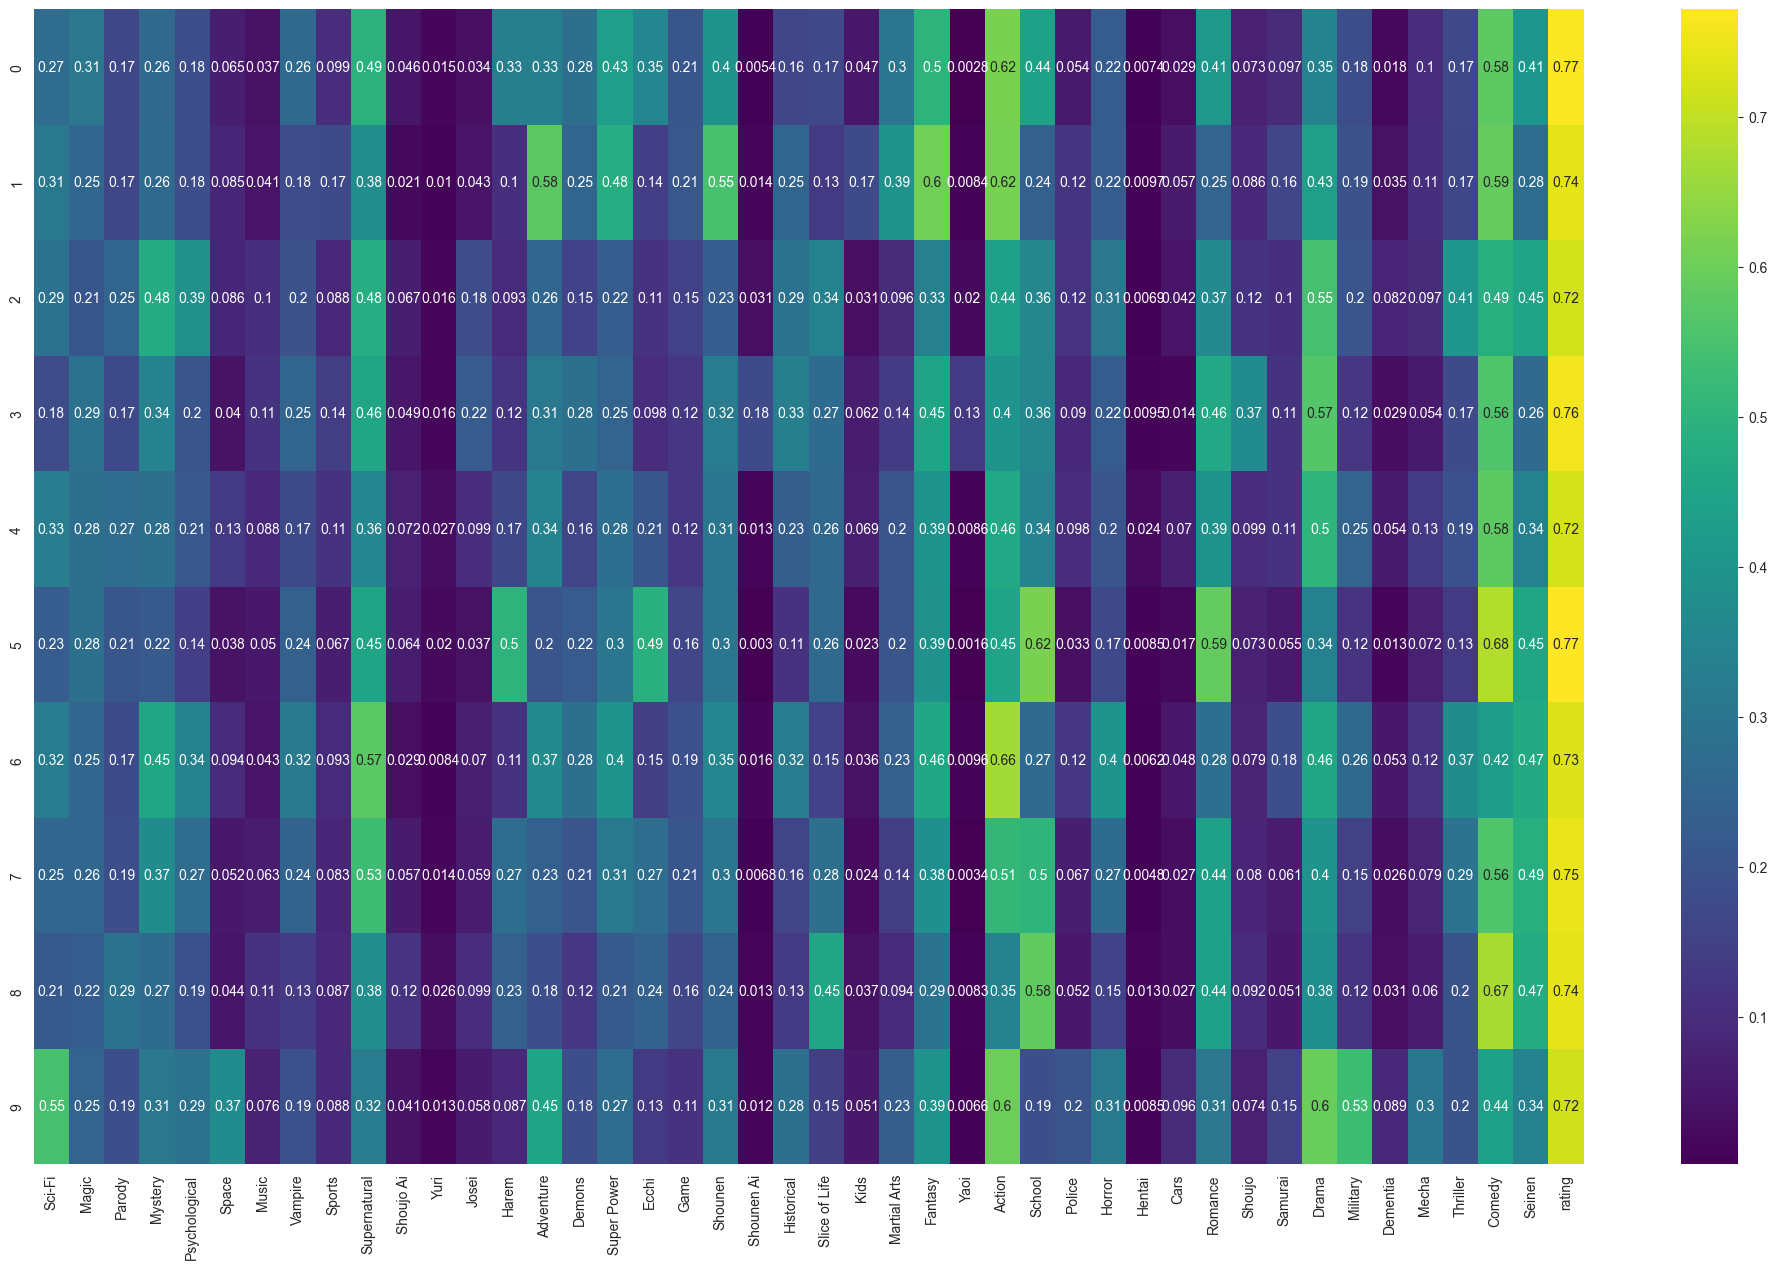

In [164]:
plt.figure(figsize=(25, 15))
sns.heatmap(kmeans.cluster_centers_, cmap='viridis', annot=True, xticklabels=merged_scaled.columns)


  0%|          | 0/29 [00:00<?, ?it/s]C:\Users\prokh\YandexDisk\МИИГАИК\Магистратура\Интеллектуальный анализ данных\KondratevPV_DataMining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\prokh\YandexDisk\МИИГАИК\Магистратура\Интеллектуальный анализ данных\KondratevPV_DataMining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\prokh\YandexDisk\МИИГАИК\Магистратура\Интеллектуальный анализ данных\KondratevPV_DataMining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the va

Text(0, 0.5, '$J(C_k)$')

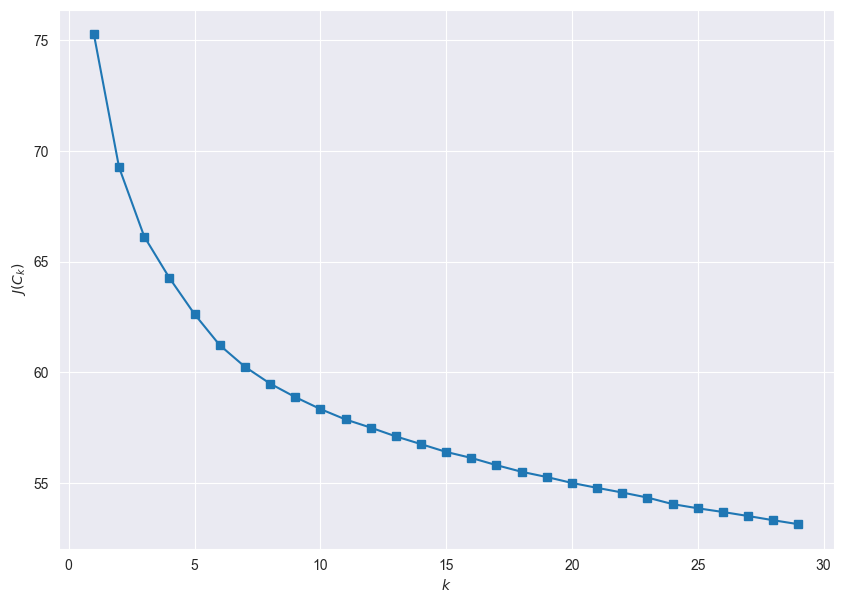

In [165]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(merged_scaled))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')



  0%|          | 0/28 [00:00<?, ?it/s]C:\Users\prokh\YandexDisk\МИИГАИК\Магистратура\Интеллектуальный анализ данных\KondratevPV_DataMining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  4%|▎         | 1/28 [00:00<00:24,  1.09it/s]C:\Users\prokh\YandexDisk\МИИГАИК\Магистратура\Интеллектуальный анализ данных\KondratevPV_DataMining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  7%|▋         | 2/28 [00:01<00:24,  1.07it/s]C:\Users\prokh\YandexDisk\МИИГАИК\Магистратура\Интеллектуальный анализ данных\KondratevPV_DataMining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: F

2

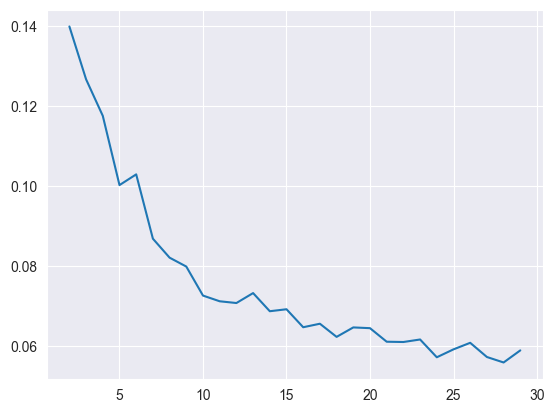

In [166]:
from sklearn.metrics import silhouette_score, silhouette_samples

def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

draw_sil_score(scaler.fit_transform(merged_scaled), range(2, 30))

In [167]:
kmeans = KMeans(n_clusters=28, random_state=42)
kmeans.fit(merged_scaled)

C:\Users\prokh\YandexDisk\МИИГАИК\Магистратура\Интеллектуальный анализ данных\KondratevPV_DataMining\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=28, random_state=42)

<Axes: >

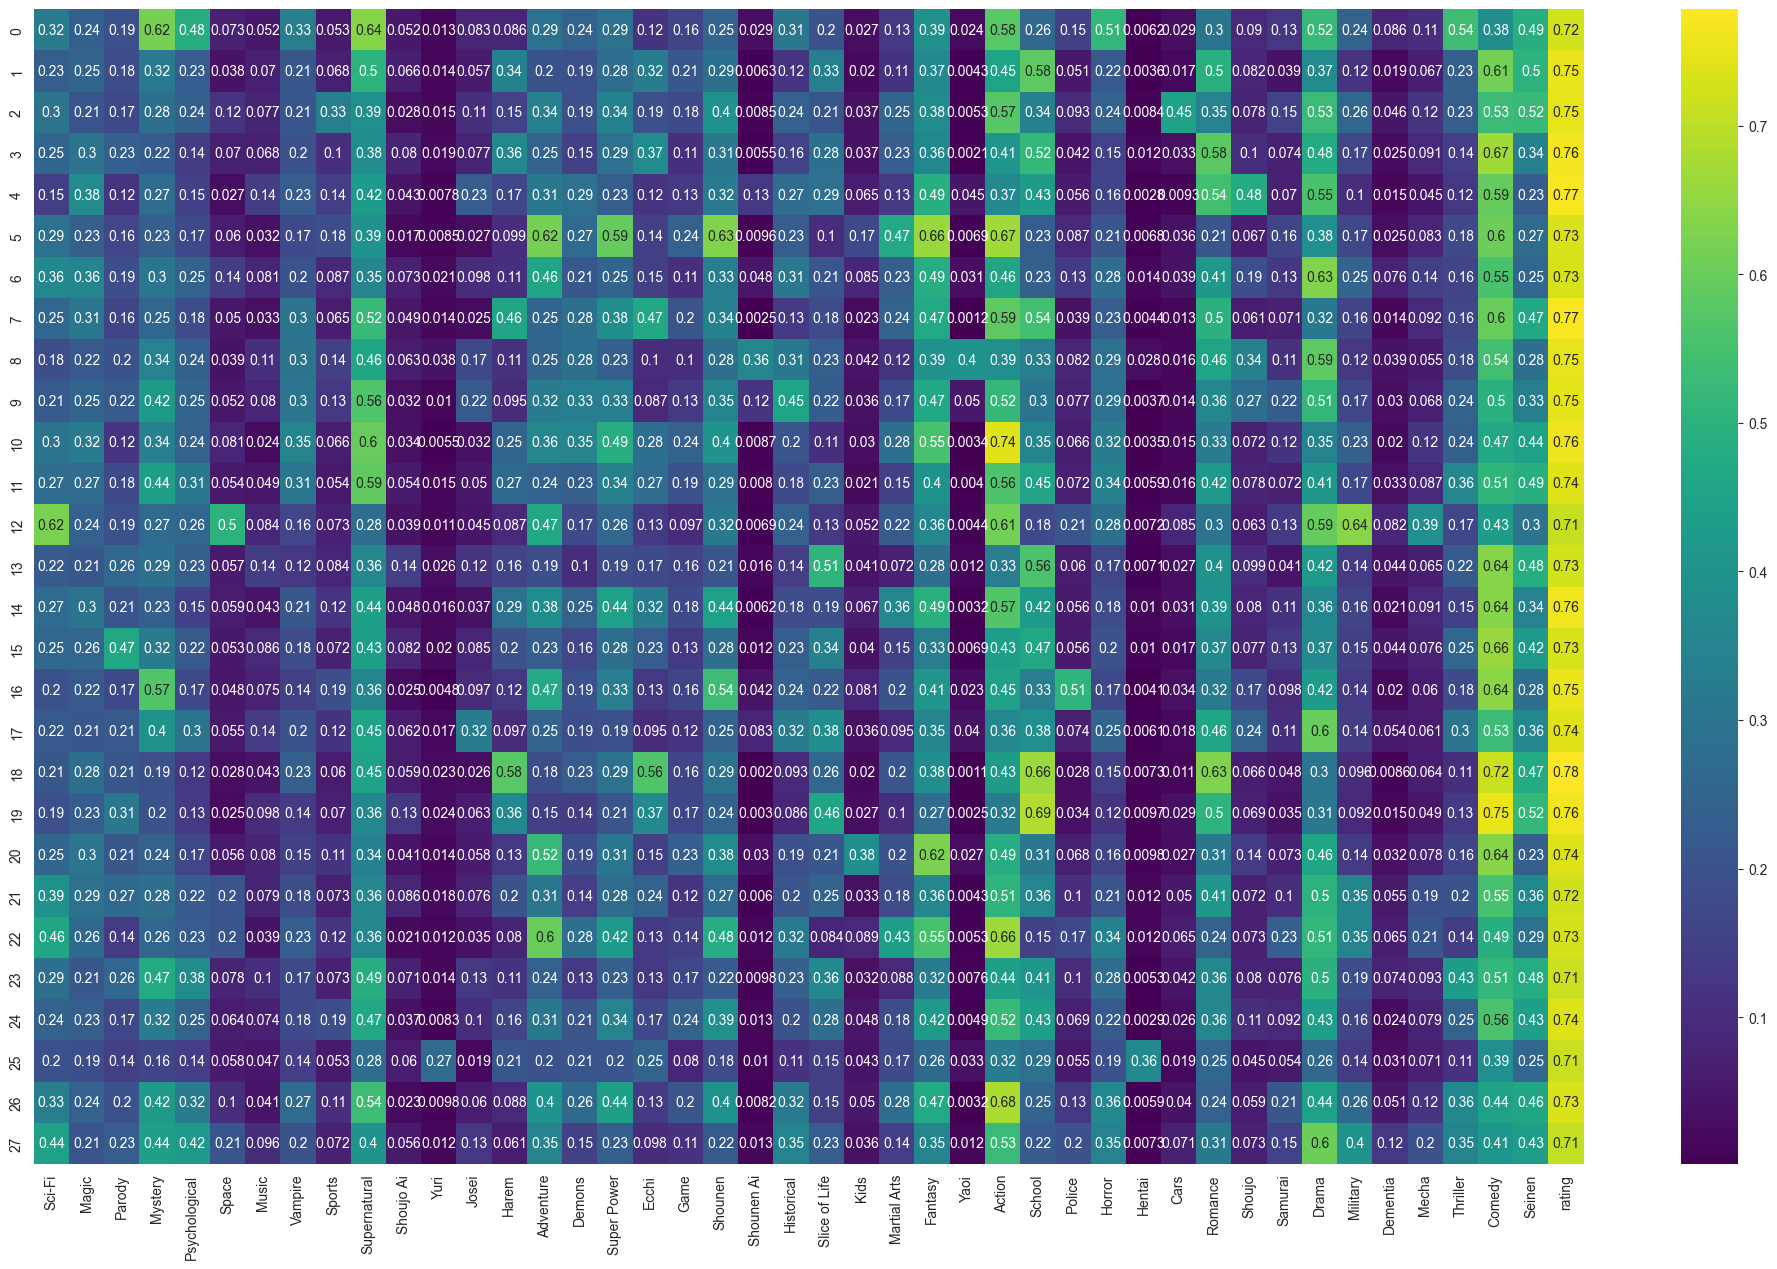

In [168]:
plt.figure(figsize=(25, 15))
sns.heatmap(kmeans.cluster_centers_, cmap='viridis', annot=True, xticklabels=merged_scaled.columns)

In [172]:
print('Пользователю скорее всего понравится аниме следующих жанров:')
print(merged_scaled.columns[np.where(merged_scaled.iloc[0] > 0)])
print('Пользователю скорее всего не понравится аниме следующих жанров:')
print(merged_scaled.columns[np.where(merged_scaled.iloc[0] == 0)])

Пользователю скорее всего понравится аниме следующих жанров:
Index(['Sci-Fi', 'Magic', 'Parody', 'Mystery', 'Psychological', 'Space',
       'Music', 'Vampire', 'Sports', 'Supernatural', 'Shoujo Ai', 'Josei',
       'Harem', 'Adventure', 'Demons', 'Super Power', 'Ecchi', 'Game',
       'Shounen', 'Historical', 'Slice of Life', 'Kids', 'Martial Arts',
       'Fantasy', 'Action', 'School', 'Police', 'Horror', 'Cars', 'Romance',
       'Shoujo', 'Samurai', 'Drama', 'Military', 'Dementia', 'Mecha',
       'Thriller', 'Comedy', 'Seinen', 'rating'],
      dtype='object')
Пользователю скорее всего не понравится аниме следующих жанров:
Index(['Yuri', 'Shounen Ai', 'Yaoi', 'Hentai'], dtype='object')
